Bölüm 1: Kütüphaneler yükleniyor...
Kütüphaneler başarıyla yüklendi.

Bölüm 2: Veri setleri işleniyor...
İşlenmek üzere 20 adet CSV dosyası bulundu.
Tüm veriler ortak zaman diliminde birleştirildi ve temizlendi.

Bölüm 3: Özellikler (X) ve Hedef (y) oluşturuluyor...
Teknik göstergeler ve yeni özellikler ekleniyor...


/tmp/ipykernel_29658/3370318816.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{col}_lag_{lag}'] = X[col].shift(lag)
/tmp/ipykernel_29658/3370318816.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{col}_lag_{lag}'] = X[col].shift(lag)
/tmp/ipykernel_29658/3370318816.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

Özellik mühendisliği tamamlandı.

Bölüm 4: Veri, eğitim ve test setlerine ayrılıyor...
Eğitim seti boyutu: (5607, 760), Test seti boyutu: (1402, 760)

Bölüm 5: XGBoost modeli eğitiliyor...


/home/codespace/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:53:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model başarıyla eğitildi!

--- MODEL DEĞERLENDİRME RAPORU ---
Doğruluk (Accuracy): 0.5956 (%59.56)

Sınıflandırma Raporu:
              precision    recall  f1-score   support

   Short (0)       0.66      0.76      0.71       896
    Long (1)       0.42      0.30      0.35       506

    accuracy                           0.60      1402
   macro avg       0.54      0.53      0.53      1402
weighted avg       0.57      0.60      0.58      1402


Karmaşıklık Matrisi:


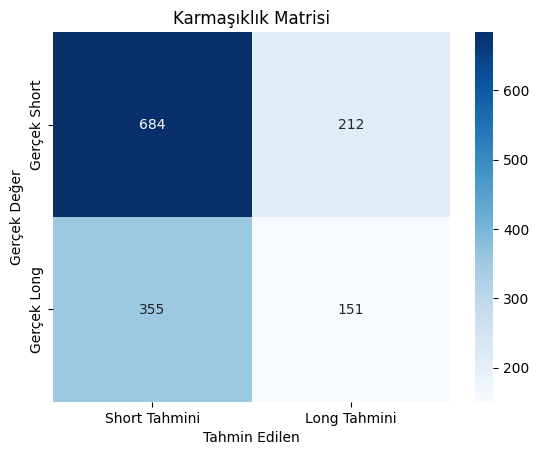

In [2]:
# ==============================================================================
# BİRLEŞTİRİLMİŞ PROJE KODU (v2 - UYUMLU MOD)
# ==============================================================================

# --- BÖLÜM 1: KÜTÜPHANELERİ YÜKLEME ---
print("Bölüm 1: Kütüphaneler yükleniyor...")
import pandas as pd
import pandas_ta as ta # Kütüphaneyi import ediyoruz
import glob
import os
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)
print("Kütüphaneler başarıyla yüklendi.\n")


# --- BÖLÜM 2: VERİLERİ İŞLEME VE BİRLEŞTİRME ---
print("Bölüm 2: Veri setleri işleniyor...")
path = '../data/*.csv'
all_files = glob.glob(path)
print(f"İşlenmek üzere {len(all_files)} adet CSV dosyası bulundu.")
processed_dfs = []
for filename in all_files:
    column_name = os.path.basename(filename).split(',')[0].replace('.csv', '')
    try:
        df = pd.read_csv(filename, usecols=['time', 'close'], parse_dates=['time'], index_col='time')
        df = df.asfreq('D').ffill()
        df.rename(columns={'close': column_name}, inplace=True)
        processed_dfs.append(df)
    except Exception as e:
        print(f"HATA: '{filename}' dosyası okunurken bir sorun oluştu: {e}")
if len(processed_dfs) > 1:
    master_df = pd.concat(processed_dfs, axis=1, join='inner').sort_index()
    print("Tüm veriler ortak zaman diliminde birleştirildi ve temizlendi.\n")


# --- BÖLÜM 3: GELİŞMİŞ ÖZELLİK MÜHENDİSLİĞİ ---
print("Bölüm 3: Özellikler (X) ve Hedef (y) oluşturuluyor...")
target_col = 'CME_MINI_ES1!'
if target_col not in master_df.columns:
    raise ValueError(f"HATA: Hedef sütun '{target_col}' veri setinde bulunamadı. Lütfen dosya adını kontrol edin.")
    
master_df['Yön'] = (master_df[target_col].shift(-1) > master_df[target_col]).astype(int)
master_df.dropna(subset=['Yön'], inplace=True)
y = master_df['Yön']
X = master_df.drop(columns=['Yön', target_col])

print("Teknik göstergeler ve yeni özellikler ekleniyor...")
for col in X.columns:
    # GÜNCELLEME: Fonksiyonları doğrudan ta.fonksiyon_adı() şeklinde çağırıyoruz
    # RSI (Göreceli Güç Endeksi)
    X[f'{col}_RSI_14'] = ta.rsi(close=X[col], length=14)
    # MACD
    macd = ta.macd(close=X[col], fast=12, slow=26, signal=9)
    if macd is not None: X = pd.concat([X, macd.add_prefix(f'{col}_')], axis=1)
    # Bollinger Bantları
    bbands = ta.bbands(close=X[col], length=20, std=2)
    if bbands is not None: X = pd.concat([X, bbands.add_prefix(f'{col}_')], axis=1)

for col in list(X.columns): # Orijinal sütun listesi üzerinde döngüye gir
    for lag in [1, 2, 3]:
        X[f'{col}_lag_{lag}'] = X[col].shift(lag)

X.dropna(inplace=True)
y = y.loc[X.index]
print("Özellik mühendisliği tamamlandı.\n")


# --- BÖLÜM 4: VERİYİ EĞİTİM VE TEST OLARAK AYIRMA ---
print("Bölüm 4: Veri, eğitim ve test setlerine ayrılıyor...")
test_size = 0.2
test_index = int(len(X) * (1 - test_size))
X_train, X_test = X.iloc[:test_index], X.iloc[test_index:]
y_train, y_test = y.iloc[:test_index], y.iloc[test_index:]
print(f"Eğitim seti boyutu: {X_train.shape}, Test seti boyutu: {X_test.shape}\n")


# --- BÖLÜM 5: XGBOOST MODELİNİ EĞİTME ---
print("Bölüm 5: XGBoost modeli eğitiliyor...")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
model = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight,
    use_label_encoder=False, n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42
)
model.fit(X_train, y_train)
print("Model başarıyla eğitildi!\n")


# --- BÖLÜM 6: MODEL PERFORMANSINI DEĞERLENDİRME ---
print("--- MODEL DEĞERLENDİRME RAPORU ---")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Doğruluk (Accuracy): {accuracy:.4f} (%{accuracy*100:.2f})\n")
print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=['Short (0)', 'Long (1)']))
print("\nKarmaşıklık Matrisi:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Short Tahmini', 'Long Tahmini'], yticklabels=['Gerçek Short', 'Gerçek Long'])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.title('Karmaşıklık Matrisi')
plt.show()

In [3]:
# HÜCRE: Optuna ile Hiperparametre Optimizasyonu

import optuna
from sklearn.metrics import f1_score

# Optimizasyon için eğitim setimizi daha da bölerek bir doğrulama seti (validation set) oluşturalım.
# Bu, test setini kirletmeden en iyi parametreleri bulmamızı sağlar.
val_size = 0.2
val_index = int(len(X_train) * (1 - val_size))
X_train_sub, X_val = X_train.iloc[:val_index], X_train.iloc[val_index:]
y_train_sub, y_val = y_train.iloc[:val_index], y_train.iloc[val_index:]


def objective(trial):
    """Optuna'nın her denemede çalıştıracağı amaç fonksiyonu."""
    
    # Denenecek hiperparametre aralıklarını tanımlıyoruz
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
    }

    # Modeli deneme parametreleriyle oluştur
    model_opt = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight, # Bu değeri bir önceki adımdan alıyoruz
        use_label_encoder=False,
        random_state=42,
        **params # Deneme parametrelerini burada modele veriyoruz
    )
    
    # Modeli alt-eğitim setiyle eğit
    model_opt.fit(X_train_sub, y_train_sub)
    
    # Doğrulama seti üzerinde tahmin yap
    preds = model_opt.predict(X_val)
    
    # Performansı F1 skoru ile ölç (Accuracy'den daha dengeli bir metrik olabilir)
    f1 = f1_score(y_val, preds)
    
    return f1

# Optimizasyon çalışmasını başlatıyoruz
# direction='maximize' -> F1 skorunu en yüksek yapmaya çalış
# n_trials=50 -> 50 farklı parametre kombinasyonu dene
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Sonuçları yazdır
print("\n--- Optimizasyon Tamamlandı! ---")
print(f"Toplam deneme sayısı: {len(study.trials)}")
print(f"En iyi F1 Skoru (Doğrulama Seti Üzerinde): {study.best_value:.4f}")
print("Bulunan En İyi Parametreler:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-21 14:00:17,951] A new study created in memory with name: no-name-11723be0-340c-4417-8977-2306b6c98793
/home/codespace/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-21 14:00:51,667] Trial 0 finished with value: 0.49673202614379086 and parameters: {'n_estimators': 819, 'max_depth': 5, 'learning_rate': 0.078356268424169, 'subsample': 0.6462266011351253, 'colsample_bytree': 0.6225012393738174, 'gamma': 2.7702856491015644}. Best is trial 0 with value: 0.49673202614379086.
/home/codespace/.local/lib/python3.12/site-packages/xgboost/training.py:1


--- Optimizasyon Tamamlandı! ---
Toplam deneme sayısı: 50
En iyi F1 Skoru (Doğrulama Seti Üzerinde): 0.5539
Bulunan En İyi Parametreler:
  n_estimators: 350
  max_depth: 5
  learning_rate: 0.011581066540296519
  subsample: 0.9480233864136867
  colsample_bytree: 0.5908073350890054
  gamma: 1.5599757716420615


Final modeli, bulunan en iyi parametrelerle eğitiliyor...


/home/codespace/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:20:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Final modeli başarıyla eğitildi!

--- FİNAL MODEL DEĞERLENDİRME RAPORU (Test Seti Üzerinde) ---
Final Model Doğruluk (Accuracy): 0.5720 (%57.20)

Final Sınıflandırma Raporu:
              precision    recall  f1-score   support

   Short (0)       0.69      0.61      0.65       896
    Long (1)       0.42      0.50      0.46       506

    accuracy                           0.57      1402
   macro avg       0.55      0.56      0.55      1402
weighted avg       0.59      0.57      0.58      1402


Final Karmaşıklık Matrisi:


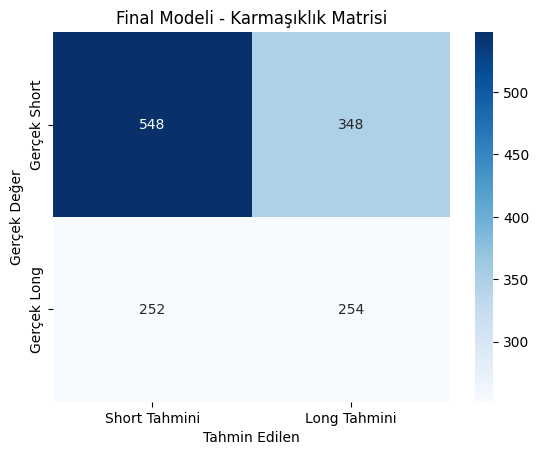

In [5]:
# HÜCRE: En İyi Parametrelerle Final Modelini Eğitme ve Değerlendirme

# Optuna'dan en iyi parametreleri al
best_params = study.best_params

# Final modelini bu parametrelerle oluştur
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42,
    **best_params # En iyi parametreleri burada kullanıyoruz
)

print("Final modeli, bulunan en iyi parametrelerle eğitiliyor...")
# Modeli TÜM eğitim verisiyle eğitiyoruz
final_model.fit(X_train, y_train)
print("✅ Final modeli başarıyla eğitildi!\n")


# --- FİNAL MODEL DEĞERLENDİRME RAPORU ---
print("--- FİNAL MODEL DEĞERLENDİRME RAPORU (Test Seti Üzerinde) ---")
y_pred_final = final_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f"Final Model Doğruluk (Accuracy): {accuracy_final:.4f} (%{accuracy_final*100:.2f})\n")
print("Final Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_final, target_names=['Short (0)', 'Long (1)']))
print("\nFinal Karmaşıklık Matrisi:")
cm_final = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['Short Tahmini', 'Long Tahmini'], yticklabels=['Gerçek Short', 'Gerçek Long'])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.title('Final Modeli - Karmaşıklık Matrisi')
plt.show()

SHAP değerleri hesaplanıyor... Bu işlem birkaç saniye sürebilir.
En Önemli 20 Özellik:


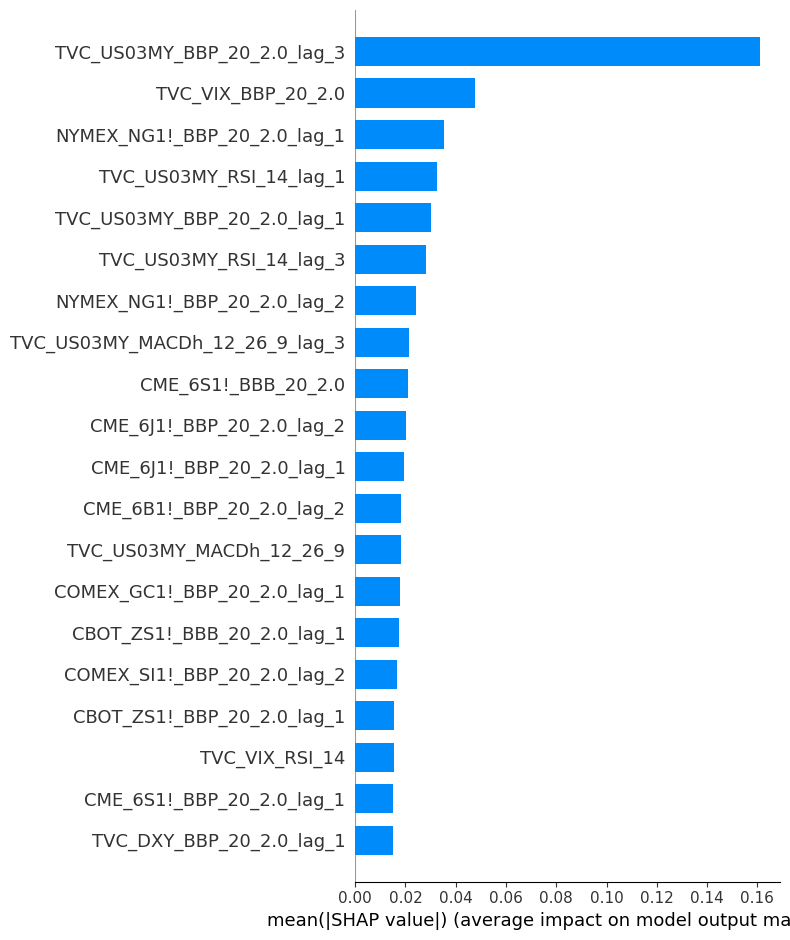

In [6]:
# HÜCRE: SHAP ile Model Kararlarını Yorumlama

import shap

print("SHAP değerleri hesaplanıyor... Bu işlem birkaç saniye sürebilir.")

# Model için bir SHAP açıklayıcısı (explainer) oluşturuyoruz
explainer = shap.TreeExplainer(final_model)

# Test seti üzerinden SHAP değerlerini hesaplıyoruz
shap_values = explainer.shap_values(X_test)

# SHAP özet grafiğini çizdiriyoruz
# Bu grafik, en etkili 20 özelliği gösterecektir
print("En Önemli 20 Özellik:")
shap.summary_plot(shap_values, X_test, max_display=20, plot_type='bar')